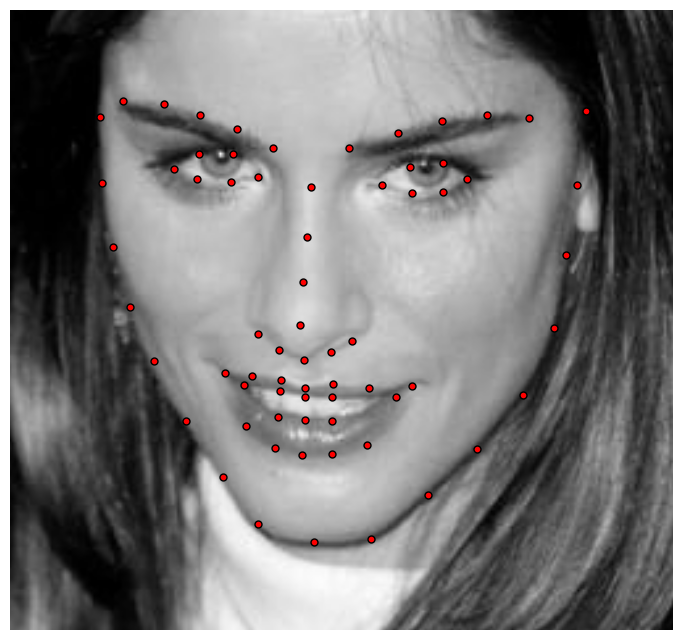

In [1]:
import menpo.io as mio
from menpo.visualize import print_progress
from menpo.landmark import labeller, face_ibug_68_to_face_ibug_68_trimesh
from menpowidgets import visualize_images
%matplotlib inline
path_to_images = '/Programing/GR/dataset/lfpw/trainset'
training_images = []

for img in print_progress(mio.import_images(path_to_images, verbose=True)):
    # convert to greyscale
    if img.n_channels == 3:
        img = img.as_greyscale()
    
    # crop to landmarks bounding box with an extra 20% padding
    img = img.crop_to_landmarks_proportion(0.2)
    
    # rescale image if its diagonal is bigger than 400 pixels
    d = img.diagonal()
    if d > 400:
        img = img.rescale(400.0 / d)
    # define a TriMesh which will be useful for Piecewise Affine Warp of HolisticAAM
    labeller(img, 'PTS', face_ibug_68_to_face_ibug_68_trimesh)
    # append to list
    training_images.append(img)

visualize_images(training_images)
    

In [26]:
import os
from menpo.landmark import labeller, face_ibug_68_to_face_ibug_68_trimesh
from menpowidgets import visualize_images
from menpofit.aam import HolisticAAM
from menpo.feature import fast_dsift
from menpo.feature import igo
from menpofit.aam import LucasKanadeAAMFitter, WibergInverseCompositional
%matplotlib inline


aam = HolisticAAM(training_images, group='face_ibug_68_trimesh', diagonal=150,
                  scales=(0.5, 1.0), holistic_features=fast_dsift, verbose=True,
                  max_shape_components=20, max_appearance_components=150)

fitter = LucasKanadeAAMFitter(aam, lk_algorithm_cls=WibergInverseCompositional,
                              n_shape=[5, 20], n_appearance=[30, 150])
print(fitter)

- Computing reference shape                                                     Computing batch 0
- Building modelsges size: [==========] 100% (811/811) - done.                  
  - Scale 0: Doneding appearance model                                          aining
  - Scale 1: Warping images: [==        ] 29% (239/811) - 00:00:04 remaining    

KeyboardInterrupt: 

D:\Program\Anaconda\envs\GR\lib\site-packages\menpo\image\base.py:2652: MenpoDeprecationWarning: This method is no longer supported and will be removed in a future version of Menpo. Use .pixels_with_channels_at_back instead.
  MenpoDeprecationWarning)


Fitting result of 68 landmark points.


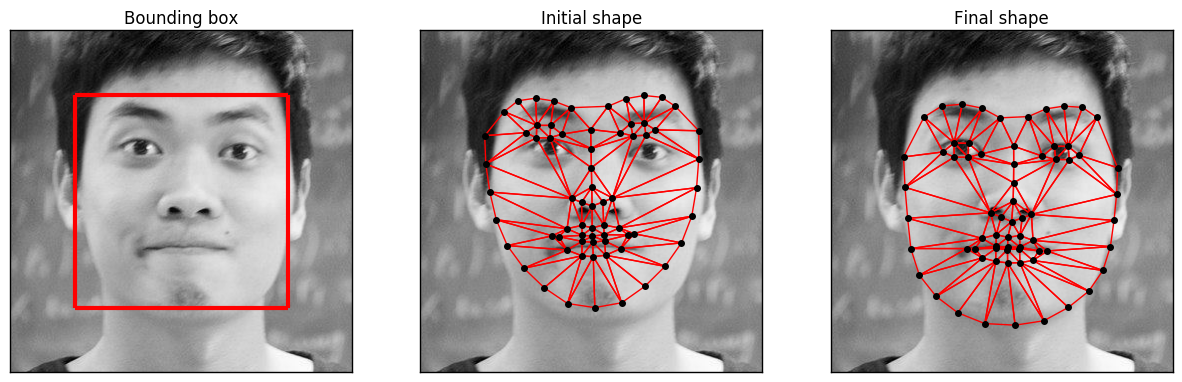

In [25]:
#harder head pose detection
from pathlib import Path
import matplotlib.pyplot as plt
from menpodetect import load_dlib_frontal_face_detector

detect = load_dlib_frontal_face_detector()
path_to_test = Path('/Programing/GR/Code/CK+/test_images')
# Load and convert to grayscale
image = mio.import_image(path_to_test / '1.jpg')
if image.n_channels == 3:
        image = image.as_greyscale()
# Detect face
bboxes = detect(image)

# Crop the image for better visualization of the result
image = image.crop_to_landmarks_proportion(0.3, group='dlib_0')
bboxes[0] = image.landmarks['dlib_0'].lms

if len(bboxes) > 0:
    # Fit AAM
    result = fitter.fit_from_bb(image, bboxes[0], max_iters=[15, 5])
    print(result)

    # Visualize
    plt.subplot(131);
    image.view()
    bboxes[0].view(line_width=3, render_markers=False)
    plt.gca().set_title('Bounding box')

    plt.subplot(132)
    image.view()
    result.initial_shape.view(marker_size=4)
    plt.gca().set_title('Initial shape')

    plt.subplot(133)
    image.view()
    result.final_shape.view(marker_size=4, figure_size=(15, 13))
    plt.gca().set_title('Final shape')